In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
sys.path.append(os.path.abspath('../..'))
from convoQC.utils import MOLECULES_DIR, load_ucc_data, load_data, UCC_DIR

# launch scripts through SLURM 

The script in the cell below submits SLURM jobs running the requested `script`, over all file names in `MOLECULES_DIR`. 

The generated SBATCH scipts (`.job` files) are saved in the `jobs` folder and then submitted.
Output and error dumps are saved in the `out` folder.

In [5]:
origin_files = list(sorted(f[:-5] for f in os.listdir(MOLECULES_DIR) 
                           if not f[:-5] + '.json' in os.listdir(UCC_DIR)))
print(*enumerate(origin_files), sep = '\n')

(0, 'H,0,0,0;H,0.4114,0,0;H,-0.4279,0.0812,0;H,-0.0788,-0.356,-0.8135')
(1, 'H,0,0,0;H,0.4313,0,0;H,0.794,-0.8148,0;H,0.3243,-0.2209,1.2635')
(2, 'H,0,0,0;H,0.4397,0,0;H,-0.0944,-0.3911,0;H,0.0922,-0.11,-0.5084')
(3, 'H,0,0,0;H,0.462,0,0;H,0.216,0.6759,0;H,-0.3769,0.2221,0.8735')
(4, 'H,0,0,0;H,0.4939,0,0;H,0.2591,-0.8605,0;H,0.8938,-0.3152,-0.5835')
(5, 'H,0,0,0;H,0.5111,0,0;H,0.6268,0.8949,0;H,0.8573,-0.2764,0.7749')
(6, 'H,0,0,0;H,0.5135,0,0;H,-0.1012,-0.7809,0;H,-0.3106,0.2094,-0.3979')
(7, 'H,0,0,0;H,0.5144,0,0;H,0.4265,0.8563,0;H,0.4625,0.0018,0.5561')
(8, 'H,0,0,0;H,0.5153,0,0;H,-0.3495,-0.5532,0;H,0.1467,-0.2604,1.0125')
(9, 'H,0,0,0;H,0.5564,0,0;H,0.8848,0.8321,0;H,0.1463,0.35,-0.8403')
(10, 'H,0,0,0;H,0.5721,0,0;H,-0.5265,-0.0077,0;H,-0.1055,1.0235,0.0868')
(11, 'H,0,0,0;H,0.5972,0,0;H,-0.3588,-0.6348,0;H,0.0857,-0.0272,-0.8654')
(12, 'H,0,0,0;H,0.6271,0,0;H,-0.6142,-0.7744,0;H,0.6178,-0.9272,0.316')
(13, 'H,0,0,0;H,0.648,0,0;H,-0.726,-0.0861,0;H,0.1668,0.5409,-0.9723')
(14, 

In [6]:
#######################
### User parameters ###
#######################

script = 'optimize_ucc.py'
time = "00-15:00"  # format days-hh:mm
mem = "100MB"  # can use postfixes (MB, GB, ...)
partition = "compIntel"

additional_lines = [
    'source ~/.bashrc\n'
]


#####################################
### Create folders, files and run ###
#####################################

current_dir = os.path.abspath('.')
script = os.path.join(*os.path.split(current_dir)[:-1], 'scripts', script)
job_dir = 'jobs'
out_dir = 'out'

os.makedirs(job_dir, exist_ok=True)
os.makedirs(out_dir, exist_ok=True)

for idx, filename in enumerate(origin_files):
    job_name = 'H4-UCC-{}'.format(idx)
    job_file = os.path.join(job_dir, job_name+'.job')
    
    with open(job_file, 'wt') as fh:
        fh.writelines(
            ["#!/bin/bash\n",
            f"#SBATCH --job-name={job_name}\n",
            f"#SBATCH --output={os.path.join(out_dir, job_name+'.out')}\n",
            f"#SBATCH --error={os.path.join(out_dir, job_name+'.err')}\n",
            f"#SBATCH --time={time}\n",
            f"#SBATCH --mem={mem}\n",
            f"#SBATCH --partition={partition}\n",
            f"#SBATCH --mail-type=NONE\n",
            ] + additional_lines + [
            f"python -u {script} '{filename}'\n"]
        )

    os.system("sbatch %s" %job_file)

# Load & analyse results 

In [7]:
ucc_files = os.listdir(UCC_DIR)
ucc_dataset = [{**load_ucc_data(f), **load_data(f)} for f in ucc_files]

infidelities, ucc_energy_errors, hf_energy_errors, nfevs, multiplicities, success, sorted_filenames = (
    np.array(a)
    for a in zip(*sorted(
        (d['infidelity'],
         d['energy_error'],
         d['hf_energy'] - d['exact_energy'],
         d['optimizer_nfev'],
         d['multiplicity'],
         d['optimizer_success'],
         f[:-5])
        for d, f in zip(ucc_dataset, ucc_files))))

## infidelity 

In [8]:
min(infidelities), max(infidelities)

(6.384521897273565e-05, 0.01446040949779559)

succeeded 500/500


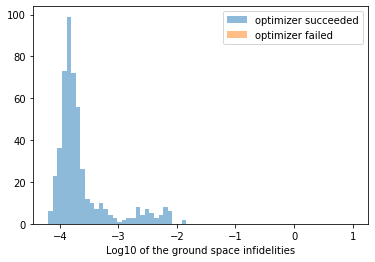

In [9]:
print(f'succeeded {sum(success)}/{len(success)}')
plt.hist(np.log10(infidelities[success]), 30, alpha=.5, label='optimizer succeeded')
plt.hist(np.log10(infidelities[np.logical_not(success)]), 30, alpha=.5, label='optimizer failed')
plt.legend()
plt.xlabel('Log10 of the ground space infidelities')
plt.show()

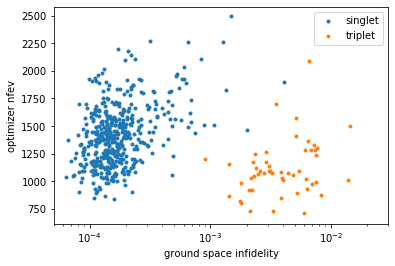

In [10]:
plt.scatter(infidelities[multiplicities==1], nfevs[multiplicities==1], label='singlet', marker = '.') 
plt.scatter(infidelities[multiplicities==3], nfevs[multiplicities==3], label='triplet', marker = '.') 
plt.xscale('log')
plt.xlim(5e-5, 0.03)
plt.xlabel('ground space infidelity')
plt.ylabel('optimizer nfev')
plt.legend()
plt.show()

## energy error

In [10]:
min(ucc_energy_errors), max(ucc_energy_errors)

(6.218245057487692e-05, 0.2617264111219366)

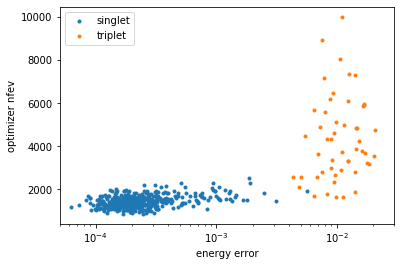

In [11]:
plt.scatter(ucc_energy_errors[multiplicities==1], nfevs[multiplicities==1], label='singlet', marker = '.') 
plt.scatter(ucc_energy_errors[multiplicities==3], nfevs[multiplicities==3], label='triplet', marker = '.') 
plt.xscale('log')
plt.xlim(5e-5, 0.03)
plt.xlabel('energy error')
plt.ylabel('optimizer nfev')
plt.legend()
plt.show()

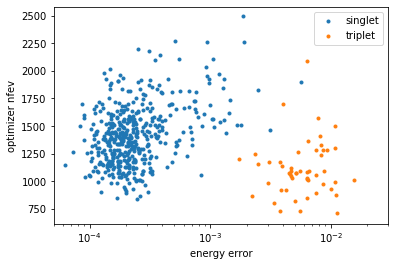

In [11]:
plt.scatter(ucc_energy_errors[multiplicities == 1],
            nfevs[multiplicities == 1], label='singlet', marker='.')
plt.scatter(ucc_energy_errors[multiplicities == 3],
            nfevs[multiplicities == 3], label='triplet', marker='.')
plt.xscale('log')
plt.xlim(5e-5, 0.03)
plt.xlabel('energy error')
plt.ylabel('optimizer nfev')
plt.legend()
plt.show()

### compare to HF 

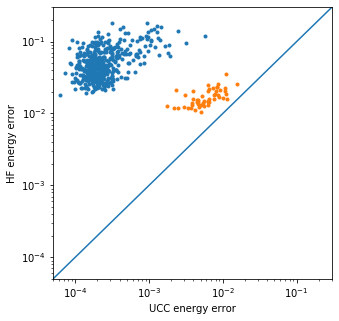

In [13]:
plt.figure(figsize=(5, 5))
plt.scatter(ucc_energy_errors[multiplicities == 1],
            hf_energy_errors[multiplicities == 1],  marker='.', label='singlet')
plt.scatter(ucc_energy_errors[multiplicities == 3],
            hf_energy_errors[multiplicities == 3],  marker='.', label='triplet')
plt.xlabel('UCC energy error')
plt.ylabel('HF energy error')
lims = (5e-5, 0.3)
plt.plot(lims, lims)
plt.xlim(*lims)
plt.ylim(*lims)
plt.yscale('log')
plt.xscale('log')

### comparison: HF energy of a triplet state 

In [24]:
from convoQC.scripts.optimize_ucc import load_molecule
from convoQC.utils import MOLECULES_DIR
for filename in os.listdir(MOLECULES_DIR):
    molecule = load_molecule(filename)
    if molecule.multiplicity == 3:
        break

In [25]:
molecule.geometry

[('H', [0.0, 0.0, 0.0]),
 ('H', [0.4114, 0.0, 0.0]),
 ('H', [-0.4279, 0.0812, 0.0]),
 ('H', [-0.0788, -0.356, -0.8135])]

In [32]:
from convoQC.vqe_functions.vqe_optimize_functions import circuit_state_expval
from convoQC.scripts.optimize_ucc import initialize_hf_state
import cirq
from openfermion import transforms

s = cirq.Simulator()

slater_singlet_energy = circuit_state_expval(
    [],
    cirq.Circuit([cirq.X(cirq.LineQubit(i)) for i in range(4)]
                 + [cirq.I(cirq.LineQubit(i)) for i in range(4, 8)]),
    {},
    transforms.jordan_wigner(
        molecule.get_molecular_hamiltonian()),
    s
)

slater_triplet_energy = circuit_state_expval(
    [],
    cirq.Circuit([cirq.X(cirq.LineQubit(i)) for i in range(3)]
                 + [cirq.I(cirq.LineQubit(3)), cirq.X(cirq.LineQubit(4))]
                 + [cirq.I(cirq.LineQubit(i)) for i in range(5, 8)]),
    {},
    transforms.jordan_wigner(
        molecule.get_molecular_hamiltonian()),
    s
)

fci = molecule.fci_energy
print('molecule filename: ', filename[:-5])
print('energy error of state |11110000>:                    ', 
      slater_singlet_energy - fci)
print('energy error of state |11101000>:                    ', 
      slater_triplet_energy - fci)
print('actual HF energy error:                              ', 
      molecule.hf_energy - fci)
print('UCC optimized energy starting from state |11110000>: ', 
      load_ucc_data(filename[:-5])['energy_error'])

molecule filename:  H,0,0,0;H,0.4114,0,0;H,-0.4279,0.0812,0;H,-0.0788,-0.356,-0.8135
energy error of state |11110000>:                     0.2010556548619562
energy error of state |11101000>:                     0.01053341859848489
actual HF energy error:                               0.010533418598552835
UCC optimized energy starting from state |11110000>:  0.014247919975318712


# develop re-optimization

## define and test a distance function between geometries 

In [24]:
from convoQC.utils import load_data

def geom_distance(filename1, filename2):
    '''
    returns n-dimensional euclidean distance between geometry configurations
    '''
    geom1 = load_data(filename1)['geometry']
    geom2 = load_data(filename2)['geometry']
    
    # strip atom names
    geom1 = np.array(list(zip(*geom1))[1]).flatten()
    geom2 = np.array(list(zip(*geom2))[1]).flatten()

    return np.sqrt(np.sum((geom1 - geom2)**2))

## visualize distances

In [38]:
distance_matrix = []

for idx1, file1 in enumerate(sorted_filenames):
    distance_matrix.append([])
    for idx2, file2 in enumerate(sorted_filenames):
        # for performance only compute the upper diagonal part, copy the lower diagonal
        if idx2 < idx1:
            distance_matrix[-1].append(distance_matrix[idx2][idx1])
        else:
            distance_matrix[-1].append(geom_distance(file1, file2))

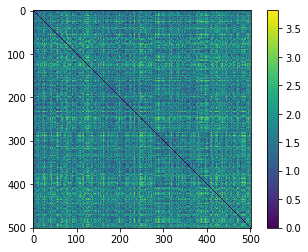

In [42]:
plt.imshow(distance_matrix)
plt.colorbar()
plt.show()

In [40]:
minima = [min(row[:i]+row[i+1:]) for i, row in enumerate(distance_matrix)]

(array([ 6.,  0., 19., 18., 33., 43., 46., 43., 49., 72., 56., 40., 19.,
        13., 13., 12.,  5., 10.,  2.,  2.]),
 array([0.14938019, 0.18532217, 0.22126415, 0.25720613, 0.29314811,
        0.32909009, 0.36503207, 0.40097405, 0.43691603, 0.47285801,
        0.50879999, 0.54474197, 0.58068395, 0.61662593, 0.65256791,
        0.68850989, 0.72445187, 0.76039385, 0.79633583, 0.83227781,
        0.86821979]),
 <a list of 20 Patch objects>)

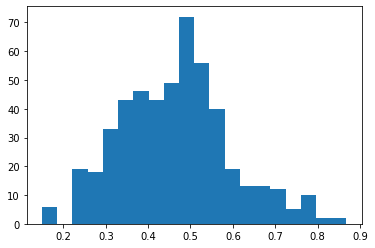

In [41]:
plt.hist(minima,20)

## sort old files by infidelity, define by a threshold which to optimize

In [25]:
infidelities, files = zip(*sorted(
    (load_ucc_data(f)['infidelity'], f[:-5]) for f in os.listdir(UCC_DIR)
))

threshold = 5E-4
threshold_idx = np.searchsorted(infidelities, threshold)

## Set up reoptimized folder

### define and create it 

In [26]:
from convoQC.utils import DATA_DIR
UCC_REOPT_DIR = DATA_DIR + 'ucc_reoptimized/'
os.makedirs(UCC_REOPT_DIR, exist_ok=True)
print(os.listdir(DATA_DIR))

['json', 'molecules', 'ucc', 'ucc_reoptimized', 'ucc_failed_triplets']


In [31]:
reopt_files = os.listdir(UCC_REOPT_DIR)
print(len(reopt_files))

71


In [32]:
for f in reopt_files:
    print(f'{(load_ucc_data(f[:-5])["infidelity"]):0.5f}  '
          f'{(load_ucc_data(UCC_REOPT_DIR + f)["infidelity"]):0.5f}')

0.00090  0.00095
0.00520  0.00513
0.00600  0.00597
0.00279  0.00249
0.00692  0.00701
0.00259  0.00275
0.00635  0.00591
0.00176  0.00178
0.00215  0.00159
0.00398  0.00424
0.00290  0.00310
0.00180  0.00164
0.00288  0.00277
0.00216  0.00181
0.00384  0.00420
0.00544  0.00522
0.00618  0.00617
0.00313  0.00296
0.00389  0.00386
0.00180  0.00073
0.00225  0.00224
0.00334  0.00165
0.00143  0.00156
0.00392  0.00408
0.00232  0.00270
0.00142  0.00176
0.00241  0.00064
0.00352  0.00422
0.00220  0.00136
0.00234  0.00207
0.00210  0.00242
0.00640  0.00414
0.00053  0.00061
0.00307  0.00310
0.00513  0.00206
0.00325  0.00044
0.00654  0.00780
0.00246  0.00170
0.00679  0.00703
0.00483  0.00180
0.00307  0.00330
0.00065  0.00049
0.00439  0.00448
0.00058  0.00058
0.00510  0.00499
0.00052  0.00055
0.00069  0.00066
0.00067  0.00061
0.00051  0.00044
0.00074  0.00074
0.00070  0.00060
0.00055  0.00055
0.00106  0.00110
0.00089  0.00084
0.00065  0.00069
0.00408  0.00408
0.00057  0.00058
0.00201  0.00199
0.00061  0.000

### clean it (CAUTION)

### copy above-threshold files to reoptimized directory

## Find best above-threshold starting point and run reopt script

In [29]:
#######################
### User parameters ###
#######################

script = 'reoptimize_ucc.py'
time = "00-10:00"  # format days-hh:mm
mem = "100MB"  # can use postfixes (MB, GB, ...)
partition = "compIntel"

additional_lines = [
    'source ~/.bashrc\n'
]


#####################################
### Create folders, files and run ###
#####################################

current_dir = os.path.abspath('.')
script = os.path.join(*os.path.split(current_dir)[:-1], 'scripts', script)
job_dir = 'jobs'
out_dir = 'out'

os.makedirs(job_dir, exist_ok=True)
os.makedirs(out_dir, exist_ok=True)
    
def slurm_run_reopt(target_filename, source_filename, idx):
    job_name = 'H4-ReUCC-{}'.format(idx)
    job_file = os.path.join(job_dir, job_name+'.job')

    with open(job_file, 'wt') as fh:
        fh.writelines(
            ["#!/bin/bash\n",
            f"#SBATCH --job-name={job_name}\n",
            f"#SBATCH --output={os.path.join(out_dir, job_name+'.out')}\n",
            f"#SBATCH --error={os.path.join(out_dir, job_name+'.err')}\n",
            f"#SBATCH --time={time}\n",
            f"#SBATCH --mem={mem}\n",
            f"#SBATCH --partition={partition}\n",
            f"#SBATCH --mail-type=NONE\n",
            ] + additional_lines + [
            f"python -u {script} '{target_filename}' '{source_filename}'\n"]
        )

    os.system("sbatch %s" %job_file)

In [30]:
script = os.path.abspath('../scripts/reoptimize_ucc.py')

for idx, file_to_reopt in enumerate(files[threshold_idx:]):
    distance, closest_file = min(
        (geom_distance(file_to_reopt, f), f) 
        for f in files[:threshold_idx]
    )
    print(distance, closest_file)
    slurm_run_reopt(file_to_reopt, closest_file, idx)

0.597322684986934 H,0,0,0;H,1.0053,0,0;H,-0.0044,-0.58,0;H,-0.2287,-0.0408,0.5511
0.3325824709752454 H,0,0,0;H,1.4721,0,0;H,0.126,0.3835,0;H,-0.5505,-0.125,-0.7364
0.2554680606259812 H,0,0,0;H,0.8475,0,0;H,-0.4509,0.1194,0;H,-1.0138,-0.864,-0.4442
0.7717999352163746 H,0,0,0;H,0.8115,0,0;H,-0.1274,0.5385,0;H,-0.4407,0.7458,0.49
0.5449673292959863 H,0,0,0;H,0.8367,0,0;H,0.2134,-0.8319,0;H,0.0412,0.2188,-0.8033
0.5414099740492412 H,0,0,0;H,1.0802,0,0;H,0.3687,-0.2217,0;H,-0.7156,-0.1478,-0.6896
0.36415522789052474 H,0,0,0;H,1.0671,0,0;H,-0.0118,-0.721,0;H,0.3209,0.5993,-0.0382
0.5026112911584856 H,0,0,0;H,1.0754,0,0;H,0.3004,0.4352,0;H,0.6201,-0.0793,1.1823
0.3998085541856252 H,0,0,0;H,1.2385,0,0;H,0.5087,1.0248,0;H,-0.177,0.1434,0.4642
0.5378304658533207 H,0,0,0;H,0.86,0,0;H,0.9069,-0.7626,0;H,0.5463,-0.5453,0.7526
0.541632449175638 H,0,0,0;H,1.1878,0,0;H,0.6045,-0.4406,0;H,0.1538,-0.0616,-1.2463
0.33705594491122687 H,0,0,0;H,0.8748,0,0;H,-0.3425,-0.2952,0;H,-0.4758,0.4916,-0.3948
0.7783